# Hardware efficiency

In [1]:
import csv
import re
import warnings

warnings.filterwarnings('ignore')

miners = []
with open('miners.csv') as datafile:
    reader = csv.DictReader(datafile)
    for rowdict in reader:
        rowdict['Power (kW)'] = float(re.search('([0-9])+',rowdict['Power']).group(0))/1000.0
        rowdict['Hashrate (Th/s)'] = float(re.search('([0-9])+',rowdict['Hashrate']).group(0))
        rowdict['alpha (kWh/Thash)']=rowdict['Power (kW)']/(rowdict['Hashrate (Th/s)']*3600)
        miners.append(rowdict)

Text(0, 0.5, 'kWh/Thash')

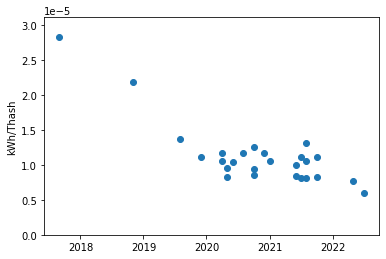

In [2]:
import matplotlib.pyplot as plt
import datetime as dt

plt.scatter(x=[dt.datetime.strptime(m['Date'], '%b %Y').date() for m in miners], 
         y=[m['alpha (kWh/Thash)'] for m in miners])
plt.ylim([0,max(m['alpha (kWh/Thash)'] for m in miners)*1.1])
plt.ylabel('kWh/Thash')

# Mining share of value

In [3]:
import pandas as pd

rev = pd.read_csv('miners-revenue.csv')
mkt = pd.read_csv('market-cap.csv')
fees = pd.read_csv('transaction-fees-usd.csv')
rev.rename({'bbbbb﻿Timestamp': 'Timestamp'}, axis=1, inplace=True)
rev.set_index('Timestamp', inplace=True)
mkt.set_index('Timestamp', inplace=True)
fees.set_index('Timestamp', inplace=True)

df = mkt.merge(rev, how='outer', on='Timestamp', sort=True)
df = df.merge(fees, how='outer', on='Timestamp', sort=True)
df.index = pd.to_datetime(df.index)
df.interpolate(method='time', inplace=True)

In [4]:
vt = df.apply(lambda row: row['miners-revenue']*365.25/row['market-cap'], axis=1)
vtf = df.apply(lambda row: row['transaction-fees-usd']*365.25/row['market-cap'], axis=1)

Text(0.5, 1.0, 'annual_miner_rev/mkt_cap')

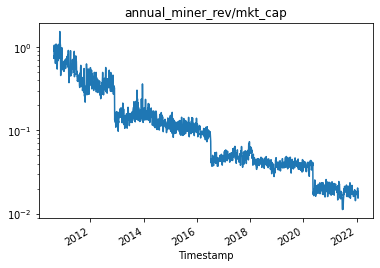

In [5]:
vt.plot()
plt.yscale('log')
plt.title('annual_miner_rev/mkt_cap')

Text(0.5, 1.0, 'annual_fees/mkt_cap')

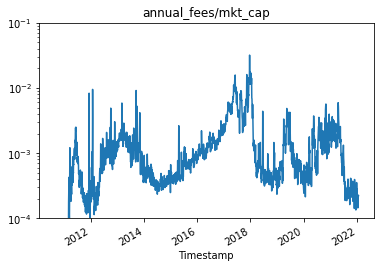

In [6]:
vtf.plot()
plt.yscale('log')
plt.ylim([1e-4,0.1])
plt.title('annual_fees/mkt_cap')

Text(0.5, 1.0, 'fees/miner_rev')

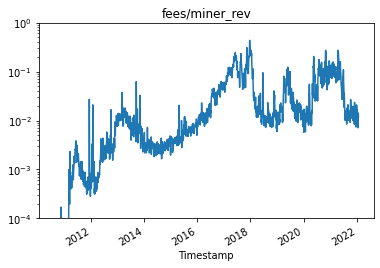

In [7]:
fr = df.apply(lambda row: row['transaction-fees-usd']/row['miners-revenue'], axis=1)
fr.plot()
plt.yscale('log')
plt.ylim([1e-4,1])
plt.title('fees/miner_rev')

# Fees as congestion price

In [8]:
txn_btc = pd.read_csv('estimated-transaction-volume.csv')
fees_btc = pd.read_csv('transaction-fees.csv')
txn_num = pd.read_csv('n-transactions.csv')
block_size = pd.read_csv('avg-block-size.csv')
txn_btc.set_index('Timestamp', inplace=True)
fees_btc.set_index('Timestamp', inplace=True)
txn_num.set_index('Timestamp', inplace=True)
block_size.set_index('Timestamp', inplace=True)

df2 = txn_btc.merge(fees_btc, how='outer', on='Timestamp', sort=True)
df2 = df2.merge(txn_num, how='outer', on='Timestamp', sort=True)
df2 = df2.merge(block_size, how='outer', on='Timestamp', sort=True)

df2.index = pd.to_datetime(df2.index)
df2.interpolate(method='time', inplace=True)
df2 = df2.loc[df2.index>pd.to_datetime('2012-07-01')]

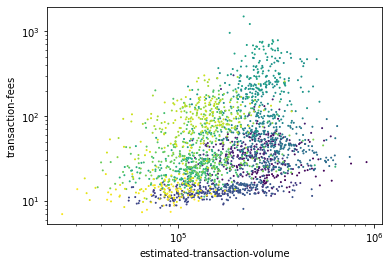

In [9]:
df2.plot.scatter(x='estimated-transaction-volume',y='transaction-fees',
                 s=1, c=df2.index, cmap='viridis')
plt.yscale('log')
plt.xscale('log')

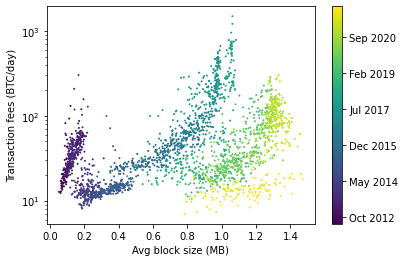

In [11]:
def timestamp_label(t):
    return dt.datetime.fromtimestamp(t/1e9).strftime('%b %Y')

plt.scatter(x=df2['avg-block-size'], y=df2['transaction-fees'],
                 s=1, c=df2.index, cmap='viridis')
plt.yscale('log')
plt.ylabel('Transaction fees (BTC/day)')
plt.xlabel('Avg block size (MB)')
cb=plt.colorbar()
cb.set_ticklabels([timestamp_label(t) for t in cb.get_ticks()])